In [26]:
# Load required libraries
library(VIM)
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)
library(moments)
library(MASS) 

In [27]:
########################## Data Loading and Initial Processing ##########################
# Load data (previously merged vehicle and pollution data)
data_veh_path <- "/kaggle/input/datasetsfaqumin/registered-vehicles-per-1000-people.csv"  
data_poll_path <- "/kaggle/input/datasetsfaqumin/global air pollution dataset.csv"

# Load datasets
data_veh1 <- read.csv(data_veh_path, header = TRUE)  
data_poll2 <- read.csv(data_poll_path, header = TRUE)

# Merge datasets
data <- left_join(data_veh1, data_poll2, by = c("Entity" = "Country"))

# Find rows with NA values
na_rows <- which(apply(data, 1, function(x) any(is.na(x))))
print("Rows containing NA values:")
print(data[na_rows, ])

# Alternative method: Using complete.cases()
incomplete_rows <- !complete.cases(data)
print("Number of rows with missing values:")
print(sum(incomplete_rows))

# You can also see which columns have NA values
na_cols <- colSums(is.na(data))
print("Number of NA values in each column:")
print(na_cols[na_cols > 0])


                       

[1] "Rows containing NA values:"
                     Entity Code Year Registered.vehicles.per.1.000.people City
82      Antigua and Barbuda  ATG 2016                            400.41788 <NA>
761                 Bolivia  BOL 2016                            153.04134 <NA>
2708             Cape Verde  CPV 2016                            126.72762 <NA>
3901           Cook Islands  COK 2014                            709.37054 <NA>
3940          Cote d'Ivoire  CIV 2016                             34.84255 <NA>
4263               Dominica  DMA 2016                            514.10350 <NA>
4302             East Timor  TLS 2016                            119.34724 <NA>
4459               Eswatini  SWZ 2016                             86.84525 <NA>
4542                   Fiji  FJI 2016                            120.50367 <NA>
6962                Grenada  GRD 2016                            236.79091 <NA>
10153                  Iran  IRN 2017                            357.26477 <NA>
12076  

In [28]:
#deleting NA rows : 29 rows
data_clean <- data[complete.cases(data), ]
# Print the dimensions before and after cleaning to see how many rows were removed
print("Original dataset dimensions:")
print(dim(data))
print("Cleaned dataset dimensions:")
print(dim(data_clean))

[1] "Original dataset dimensions:"
[1] 17224    15
[1] "Cleaned dataset dimensions:"
[1] 17195    15


In [29]:
data <- data_clean
str(data)                       
summary(data)

'data.frame':	17195 obs. of  15 variables:
 $ Entity                              : chr  "Afghanistan" "Afghanistan" "Afghanistan" "Afghanistan" ...
 $ Code                                : chr  "AFG" "AFG" "AFG" "AFG" ...
 $ Year                                : int  2013 2013 2013 2013 2013 2013 2013 2013 2013 2013 ...
 $ Registered.vehicles.per.1.000.people: num  20.7 20.7 20.7 20.7 20.7 ...
 $ City                                : chr  "Kuhestan" "Qunduz" "Rostaq" "Tokzar" ...
 $ AQI.Value                           : int  151 117 113 77 67 57 83 72 104 99 ...
 $ AQI.Category                        : chr  "Unhealthy" "Unhealthy for Sensitive Groups" "Unhealthy for Sensitive Groups" "Moderate" ...
 $ CO.AQI.Value                        : int  1 1 1 1 0 0 1 1 0 1 ...
 $ CO.AQI.Category                     : chr  "Good" "Good" "Good" "Good" ...
 $ Ozone.AQI.Value                     : int  41 44 42 40 37 38 41 44 34 49 ...
 $ Ozone.AQI.Category                  : chr  "Good" "Good" "Go

    Entity              Code                Year     
 Length:17195       Length:17195       Min.   :2007  
 Class :character   Class :character   1st Qu.:2015  
 Mode  :character   Mode  :character   Median :2016  
                                       Mean   :2016  
                                       3rd Qu.:2016  
                                       Max.   :2017  
 Registered.vehicles.per.1.000.people     City             AQI.Value     
 Min.   :  4.457                      Length:17195       Min.   :  7.00  
 1st Qu.:158.147                      Class :character   1st Qu.: 40.00  
 Median :461.903                      Mode  :character   Median : 57.00  
 Mean   :427.863                                         Mean   : 76.95  
 3rd Qu.:652.578                                         3rd Qu.: 88.00  
 Max.   :949.482                                         Max.   :500.00  
 AQI.Category        CO.AQI.Value    CO.AQI.Category    Ozone.AQI.Value 
 Length:17195       Min.   : 0.

In [30]:
# Average AQI by year
yearly_aqi <- aggregate(AQI.Value ~ Year, data = data, FUN = mean)
print("Average AQI by Year:")
print(yearly_aqi)

[1] "Average AQI by Year:"
  Year AQI.Value
1 2007  46.33333
2 2012  38.00000
3 2013  96.39744
4 2014  53.94382
5 2015  97.92146
6 2016  66.66403
7 2017  58.10386


In [31]:
# Cell 3: Initial Data Quality Checks
# Check for duplicates
duplicates <- sum(duplicated(data))
print(paste("Number of duplicate rows:", duplicates))

# Initial missing value check
missing_initial <- colSums(is.na(data))
print("Initial missing values:")
print(missing_initial)

[1] "Number of duplicate rows: 0"
[1] "Initial missing values:"
                              Entity                                 Code 
                                   0                                    0 
                                Year Registered.vehicles.per.1.000.people 
                                   0                                    0 
                                City                            AQI.Value 
                                   0                                    0 
                        AQI.Category                         CO.AQI.Value 
                                   0                                    0 
                     CO.AQI.Category                      Ozone.AQI.Value 
                                   0                                    0 
                  Ozone.AQI.Category                        NO2.AQI.Value 
                                   0                                    0 
                    NO2.AQI.Category

In [32]:
# Define variable groups
numeric_vars <- c("Registered.vehicles.per.1.000.people", "AQI.Value", 
                 "Ozone.AQI.Value", "PM2.5.AQI.Value")
categorical_vars <- c("AQI.Category", "CO.AQI.Category", "NO2.AQI.Category", 
                     "Ozone.AQI.Category", "PM2.5.AQI.Category")
special_vars <- c("CO.AQI.Value", "NO2.AQI.Value")

# Store original special variables
original_CO <- data$CO.AQI.Value
original_NO2 <- data$NO2.AQI.Value

# Handle outliers for numeric variables
for (var in numeric_vars) {
    q1 <- quantile(data[[var]], 0.25, na.rm = TRUE)
    q3 <- quantile(data[[var]], 0.75, na.rm = TRUE)
    iqr <- q3 - q1
    outliers <- data[[var]] < (q1 - 1.5 * iqr) | data[[var]] > (q3 + 1.5 * iqr)
    data[[var]][outliers] <- NA
    print(paste("Outliers in", var, ":", sum(outliers, na.rm = TRUE)))
}


[1] "Outliers in Registered.vehicles.per.1.000.people : 0"
[1] "Outliers in AQI.Value : 1699"
[1] "Outliers in Ozone.AQI.Value : 1370"
[1] "Outliers in PM2.5.AQI.Value : 1344"


In [33]:
# KNN imputation for numeric variables
numeric_data <- data[c(numeric_vars, special_vars)]
imputed_data <- kNN(numeric_data, k = 5)

# Replace imputed values
for(var in c(numeric_vars, special_vars)) {
    data[[var]] <- imputed_data[[var]]
}

# Restore original special variables where not NA
data$CO.AQI.Value[!is.na(original_CO)] <- original_CO[!is.na(original_CO)]
data$NO2.AQI.Value[!is.na(original_NO2)] <- original_NO2[!is.na(original_NO2)]

# Check remaining NAs
print("Missing values after imputation:")
print(colSums(is.na(data)))

[1] "Missing values after imputation:"
                              Entity                                 Code 
                                   0                                    0 
                                Year Registered.vehicles.per.1.000.people 
                                   0                                    0 
                                City                            AQI.Value 
                                   0                                    0 
                        AQI.Category                         CO.AQI.Value 
                                   0                                    0 
                     CO.AQI.Category                      Ozone.AQI.Value 
                                   0                                    0 
                  Ozone.AQI.Category                        NO2.AQI.Value 
                                   0                                    0 
                    NO2.AQI.Category                      PM2

,Registered.vehicles.per.1.000.people,AQI.Value,CO.AQI.Value,NO2.AQI.Value,Ozone.AQI.Value,PM2.5.AQI.Value
Registered.vehicles.per.1.000.people,1.000,-0.470,-0.229,-0.002,0.139,-0.484
AQI.Value,-0.470,1.000,0.539,0.336,0.234,0.985
CO.AQI.Value,-0.229,0.539,1.000,0.657,-0.045,0.531
NO2.AQI.Value,-0.002,0.336,0.657,1.000,-0.291,0.349
Ozone.AQI.Value,0.139,0.234,-0.045,-0.291,1.000,0.177
PM2.5.AQI.Value,-0.484,0.985,0.531,0.349,0.177,1.000


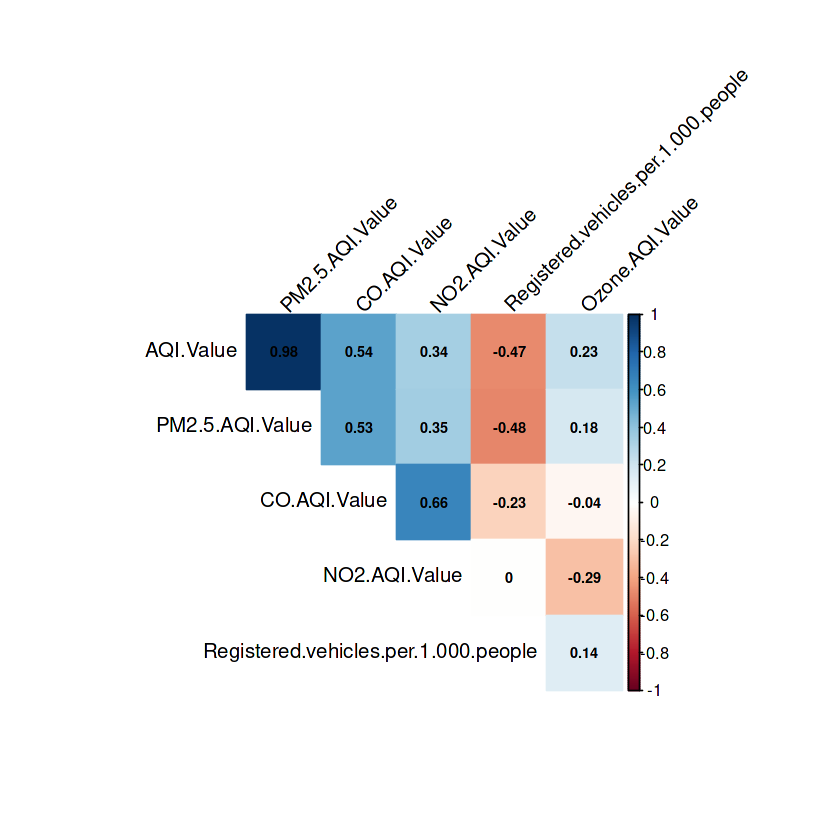

In [34]:
# Define numeric variables to include in correlation matrix
numeric_vars <- c("Registered.vehicles.per.1.000.people", "AQI.Value", 
                 "CO.AQI.Value", "NO2.AQI.Value", 
                 "Ozone.AQI.Value", "PM2.5.AQI.Value")

# Create correlation matrix
cor_matrix <- cor(data[numeric_vars], use = "complete.obs")

# Load required package
library(corrplot)

# Create correlation plot
corrplot(cor_matrix, 
         method = "color",      # Use colors to represent correlations
         type = "upper",        # Show only upper triangle
         order = "hclust",      # Order variables by hierarchical clustering
         tl.col = "black",      # Text label color
         tl.srt = 45,          # Rotate text labels 45 degrees
         addCoef.col = "black", # Add correlation coefficients in black
         number.cex = 0.7,      # Size of correlation coefficients
         diag = FALSE)         # Don't show diagonal (correlations of 1)

# Print correlation matrix with rounded values for reference
round(cor_matrix, 3)

In [35]:
# Cell 7: Distribution Analysis
distribution_summary <- data.frame(
    Variable = character(),
    Skewness = numeric(),
    Kurtosis = numeric(),
    Shapiro_P = numeric(),
    stringsAsFactors = FALSE
)

for(var in c(numeric_vars, special_vars)) {
    # Calculate statistics
    skew <- skewness(data[[var]], na.rm = TRUE)
    kurt <- kurtosis(data[[var]], na.rm = TRUE)
    
    # Shapiro test on sample if needed
    sample_data <- if(length(data[[var]]) > 5000) {
        sample(data[[var]], 5000)
    } else {
        data[[var]]
    }
    shapiro_p <- shapiro.test(sample_data)$p.value
    
    # Add to summary
    distribution_summary <- rbind(distribution_summary,
                                data.frame(Variable = var,
                                         Skewness = skew,
                                         Kurtosis = kurt,
                                         Shapiro_P = shapiro_p))
}

print("Distribution Analysis:")
print(distribution_summary)

[1] "Distribution Analysis:"
                              Variable   Skewness   Kurtosis    Shapiro_P
1 Registered.vehicles.per.1.000.people 0.08333046   1.707021 2.538281e-43
2                            AQI.Value 0.99557372   2.714059 3.225408e-56
3                         CO.AQI.Value 8.75102520 255.434551 2.100294e-74
4                        NO2.AQI.Value 4.87096042  41.409858 1.588687e-76
5                      Ozone.AQI.Value 0.03928644   2.785335 4.578545e-16
6                      PM2.5.AQI.Value 0.92093229   2.709320 4.341246e-53
7                         CO.AQI.Value 8.75102520 255.434551 2.394191e-82
8                        NO2.AQI.Value 4.87096042  41.409858 4.441134e-77


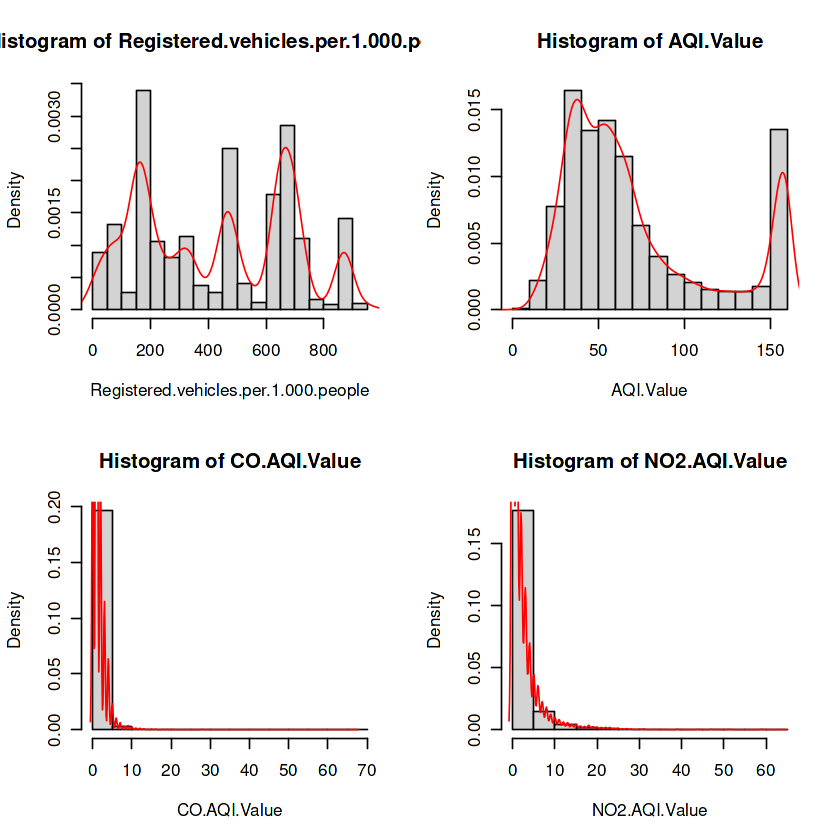


Shapiro-Wilk Normality Test Results:

Registered.vehicles.per.1.000.people: p-value = 2.5480e-43 | Non-normal

AQI.Value           : p-value = 1.0073e-56 | Non-normal

CO.AQI.Value        : p-value = 1.1246e-81 | Non-normal

NO2.AQI.Value       : p-value = 2.1470e-78 | Non-normal

Ozone.AQI.Value     : p-value = 4.5690e-16 | Non-normal

PM2.5.AQI.Value     : p-value = 2.9742e-53 | Non-normal

CO.AQI.Value        : p-value = 1.1246e-81 | Non-normal

NO2.AQI.Value       : p-value = 2.1470e-78 | Non-normal


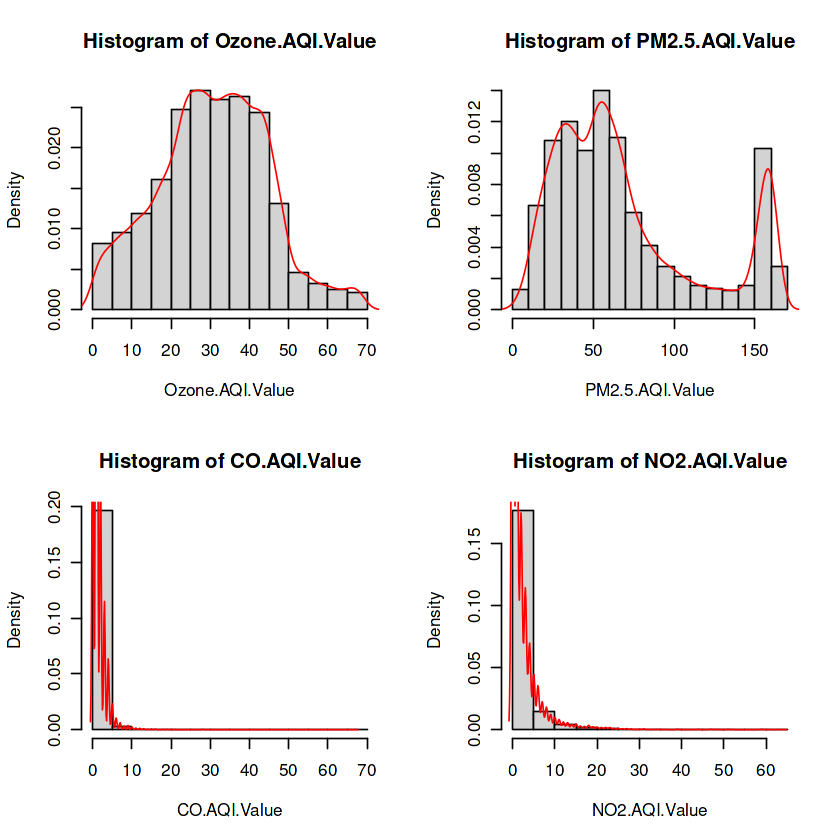

In [36]:
########################## Normality Tests ##########################
# Visual check with histograms
par(mfrow = c(2, 2))
for (var in c(numeric_vars, special_vars)) {
    hist(data[[var]], 
         main = paste("Histogram of", var),
         xlab = var,
         prob = TRUE)
    lines(density(data[[var]], na.rm = TRUE), col = "red")
}
par(mfrow = c(1, 1))

# Clear and concise normality test results
cat("\nShapiro-Wilk Normality Test Results:\n")
cat("=====================================\n")
for (var in c(numeric_vars, special_vars)) {
    # Sample data if too large
    data_sample <- data[[var]]
    if (length(data_sample) > 5000) {
        set.seed(123)
        data_sample <- sample(data_sample, 5000)
    }
    
    if (length(data_sample) >= 3) {
        shapiro_test <- shapiro.test(data_sample)
        cat(sprintf("\n%-20s: ", var))
        cat(sprintf("p-value = %.4e | ", shapiro_test$p.value))
        
        # Simple conclusion
        if (shapiro_test$p.value > 0.05) {
            cat("Normal")
        } else {
            cat("Non-normal")
        }
        cat("\n")
    }
}

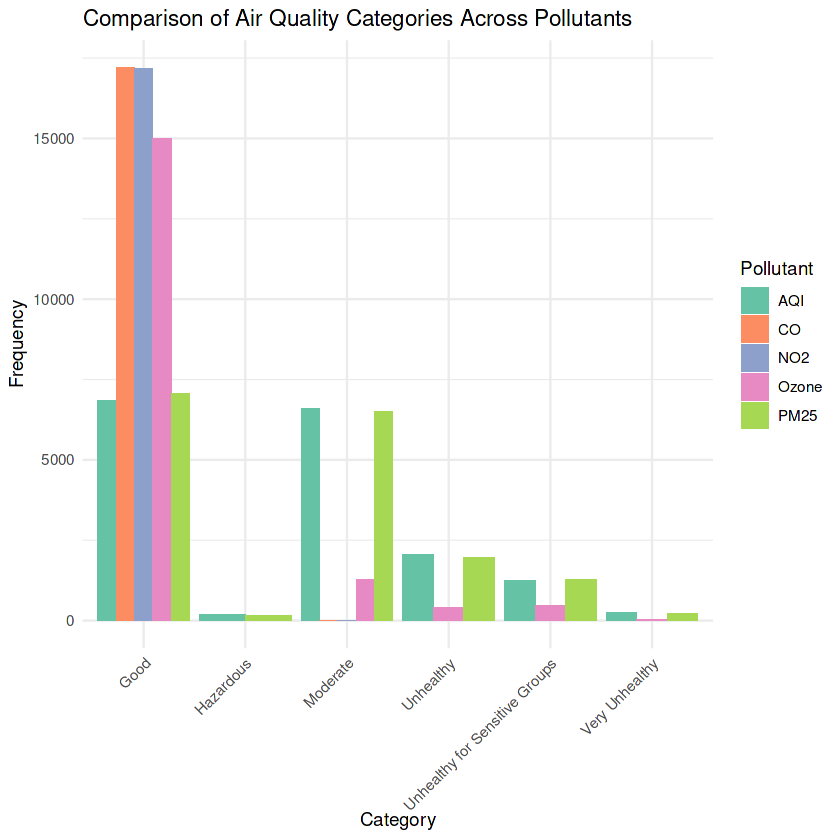

In [37]:
########################## Modality visuals for categorical variables ##########################

# Prepare data for combined plot
combined_data <- data.frame(
    AQI = data$AQI.Category,
    CO = data$CO.AQI.Category,
    Ozone = data$Ozone.AQI.Category,
    NO2 = data$NO2.AQI.Category,
    PM25 = data$PM2.5.AQI.Category
) %>%
    gather(key = "Pollutant", value = "Category")

# Create combined plot
ggplot(combined_data, aes(x = Category, fill = Pollutant)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    labs(title = "Comparison of Air Quality Categories Across Pollutants",
         x = "Category",
         y = "Frequency") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_brewer(palette = "Set2")

In [38]:
########################## Modality for categorical variables ##########################
# Function to test modality for categorical variables
test_cat_modality <- function(x) {
    freq <- table(x)
    max_freq <- max(freq)
    modes <- names(freq)[freq == max_freq]
    mode_prop <- max_freq/sum(freq)
    
    return(list(
        n_modes = length(modes),
        modes = modes,
        mode_proportion = mode_prop,
        frequencies = freq
    ))
}

# Print header
cat("\nCategorical Variables Modality Analysis\n")
cat("=======================================\n")

# Test modality for each categorical variable
cat_vars <- c("AQI.Category", "CO.AQI.Category", "Ozone.AQI.Category", 
              "NO2.AQI.Category", "PM2.5.AQI.Category")

for(var in cat_vars) {
    result <- test_cat_modality(data[[var]])
    
    # Print results in a clear format
    cat(sprintf("\n%-20s", var))
    cat("\n-------------------\n")
    
    # Print frequency table in a clean format
    cat("\nFrequency Distribution:\n")
    freq_table <- as.data.frame(result$frequencies)
    names(freq_table) <- c("Category", "Count")
    freq_table$Percentage <- (freq_table$Count / sum(freq_table$Count)) * 100
    print(data.frame(
        Category = freq_table$Category,
        Count = freq_table$Count,
        Percentage = sprintf("%.1f%%", freq_table$Percentage)
    ))
    cat("\n")
}


Categorical Variables Modality Analysis

AQI.Category        
-------------------

Frequency Distribution:
                        Category Count Percentage
1                           Good  6848      39.8%
2                      Hazardous   181       1.1%
3                       Moderate  6598      38.4%
4                      Unhealthy  2053      11.9%
5 Unhealthy for Sensitive Groups  1257       7.3%
6                 Very Unhealthy   258       1.5%


CO.AQI.Category     
-------------------

Frequency Distribution:
  Category Count Percentage
1     Good 17194     100.0%
2 Moderate     1       0.0%


Ozone.AQI.Category  
-------------------

Frequency Distribution:
                        Category Count Percentage
1                           Good 15009      87.3%
2                       Moderate  1280       7.4%
3                      Unhealthy   393       2.3%
4 Unhealthy for Sensitive Groups   465       2.7%
5                 Very Unhealthy    48       0.3%


NO2.AQI.Category    


Statistical Summary:
                                 Variable Spearman_Correlation       P_Value
rho                                  Year              -0.1616 5.531918e-101
rho1 Registered.vehicles.per.1.000.people              -0.4126  0.000000e+00
rho2                         CO.AQI.Value               0.6145  0.000000e+00
rho3                      Ozone.AQI.Value               0.2829 8.291877e-314
rho4                        NO2.AQI.Value               0.2419 1.790268e-227
rho5                      PM2.5.AQI.Value               0.9730  0.000000e+00
     Interpretation Direction
rho            Weak  Negative
rho1       Moderate  Negative
rho2       Moderate  Positive
rho3           Weak  Positive
rho4           Weak  Positive
rho5         Strong  Positive

Detailed Correlation Analysis Results:

Correlation between AQI.Value and Year :
Correlation coefficient (rho): -0.1616
p-value: 5.532e-101
Interpretation: Weak correlation
Direction: Negative (as one increases, the other tends 

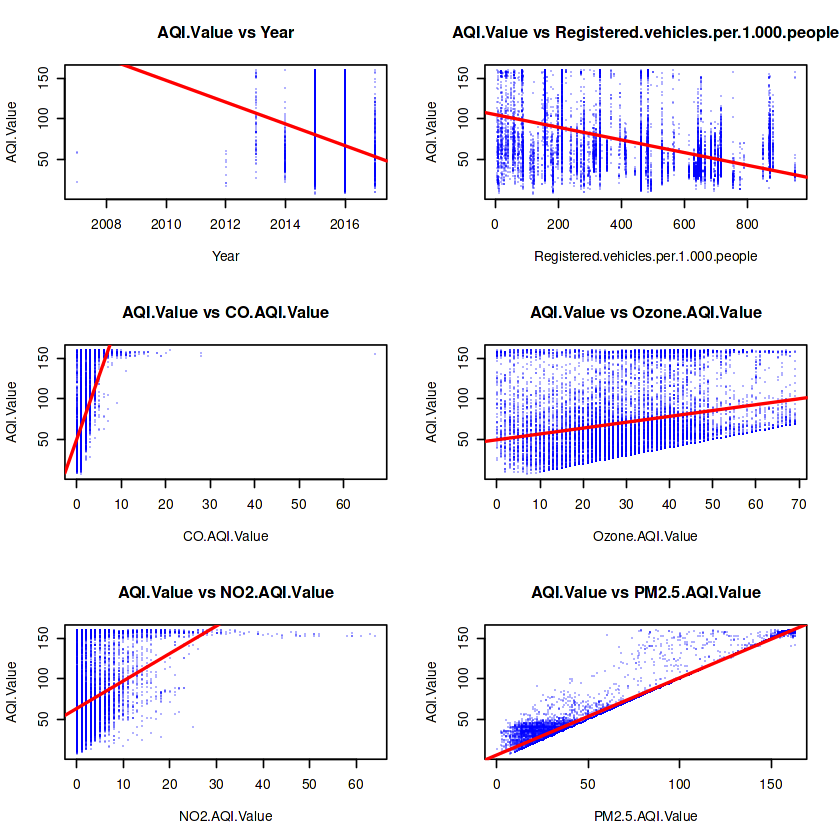

In [39]:
########################## Study Correlations ##########################

# Function for correlation analysis
correlation_analysis <- function(data) {
    numeric_vars <- c("Year", "Registered.vehicles.per.1.000.people", "CO.AQI.Value", 
                     "Ozone.AQI.Value", "NO2.AQI.Value", "PM2.5.AQI.Value")
    
    # Create results dataframe for summary
    results <- data.frame(
        Variable = character(),
        Spearman_Correlation = numeric(),
        P_Value = numeric(),
        Interpretation = character(),
        Direction = character(),
        stringsAsFactors = FALSE
    )
    
    # 1. Perform analysis and store results for summary
    for(var in numeric_vars) {
        cor_test <- cor.test(data[[var]], data$AQI.Value, 
                            method = "spearman",
                            exact = FALSE)
        
        rho <- abs(cor_test$estimate)
        interpretation <- if(rho < 0.3) "Weak" else if(rho < 0.7) "Moderate" else "Strong"
        direction <- if(cor_test$estimate > 0) "Positive" else "Negative"
        
        results <- rbind(results,
                        data.frame(Variable = var,
                                 Spearman_Correlation = round(cor_test$estimate, 4),
                                 P_Value = cor_test$p.value,
                                 Interpretation = interpretation,
                                 Direction = direction))
    }
    
    # Print Statistical Summary
    cat("\nStatistical Summary:\n")
    cat("==================\n")
    print(results)
    
    # 2. Print detailed correlation results
    cat("\nDetailed Correlation Analysis Results:\n")
    cat("===================================\n")
    
    for(var in numeric_vars) {
        cor_test <- cor.test(data[[var]], data$AQI.Value, 
                            method = "spearman",
                            exact = FALSE)
        
        rho <- abs(cor_test$estimate)
        interpretation <- if(rho < 0.3) "Weak" else if(rho < 0.7) "Moderate" else "Strong"
        direction <- if(cor_test$estimate > 0) "Positive" else "Negative"
        
        cat(sprintf("\nCorrelation between AQI.Value and %s :\n", var))
        cat(sprintf("Correlation coefficient (rho): %.4f\n", cor_test$estimate))
        cat(sprintf("p-value: %.3e\n", cor_test$p.value))
        cat(sprintf("Interpretation: %s correlation\n", interpretation))
        cat(sprintf("Direction: %s (as one increases, the other tends to %s)\n", 
                   direction, 
                   if(direction == "Positive") "increase" else "decrease"))
    }
    
    # 3. Create visualizations last
    cat("\nGenerating Correlation Plots:\n")
    cat("===========================\n")
    par(mfrow = c(3, 2))
    for(var in numeric_vars) {
        plot(data[[var]], data$AQI.Value,
             main = paste("AQI.Value vs", var),
             xlab = var,
             ylab = "AQI.Value",
             pch = ".",
             col = rgb(0, 0, 1, 0.3))
        abline(lm(AQI.Value ~ data[[var]], data = data), 
               col = "red", 
               lwd = 2)
    }
    par(mfrow = c(1, 1))
    
    # Return results invisibly
    invisible(results)
}

# Run the analysis
results <- correlation_analysis(data)

In [40]:
########################## Kruskall Wallis Test ##########################

In [42]:
# Define all categorical variables
categorical_vars <- c("Entity", "City", "CO.AQI.Category", "NO2.AQI.Category", 
                     "Ozone.AQI.Category", "PM2.5.AQI.Category")

# Create results dataframe
results <- data.frame(
    Variable = character(),
    Chi_Square = numeric(),
    P_Value = numeric(),
    Significant = character(),
    stringsAsFactors = FALSE
)

In [43]:
# Perform Kruskal-Wallis test for all variables
for(var in categorical_vars) {
    ranked_aqi <- as.numeric(factor(data$AQI.Category))
    ranked_var <- as.numeric(factor(data[[var]]))
    
    kw_test <- kruskal.test(ranked_aqi ~ data[[var]])
    
    results <- rbind(results, data.frame(
        Variable = var,
        Chi_Square = round(kw_test$statistic, 2),
        P_Value = format(kw_test$p.value, scientific = TRUE, digits = 3),
        Significant = ifelse(kw_test$p.value < 0.05, "Yes", "No"),
        stringsAsFactors = FALSE
    ))
}

# Sort by Chi-Square value
results <- results[order(-results$Chi_Square),]

In [44]:
# Print clean summary
cat("\n=== Kruskal-Wallis Analysis Summary ===\n")

# First show location variables
cat("\nLocation Variables:")
cat("\n------------------")
for(var in c("Entity", "City")) {
    row <- results[results$Variable == var,]
    cat(sprintf("\n\n%s:", var))
    cat(sprintf("\n- Chi-Square: %.2f", row$Chi_Square))
    cat(sprintf("\n- P-value: %s", row$P_Value))
    cat(sprintf("\n- Significant: %s", row$Significant))
}

# Then show pollutant categories
cat("\n\nPollutant Categories (Ranked by Chi-Square):")
cat("\n----------------------------------------")
pollutants <- results[!results$Variable %in% c("Entity", "City"),]
pollutants <- pollutants[order(-pollutants$Chi_Square),]
for(i in 1:nrow(pollutants)) {
    cat(sprintf("\n\n%d. %s", i, pollutants$Variable[i]))
    cat(sprintf("\n   Chi-Square: %.2f", pollutants$Chi_Square[i]))
    cat(sprintf("\n   P-value: %s", pollutants$P_Value[i]))
    cat(sprintf("\n   Significant: %s", pollutants$Significant[i]))
}


=== Kruskal-Wallis Analysis Summary ===

Location Variables:
------------------

Entity:
- Chi-Square: 7608.98
- P-value: 0e+00
- Significant: Yes

City:
- Chi-Square: 17194.00
- P-value: 4.99e-01
- Significant: No

Pollutant Categories (Ranked by Chi-Square):
----------------------------------------

1. PM2.5.AQI.Category
   Chi-Square: 16495.39
   P-value: 0e+00
   Significant: Yes

2. Ozone.AQI.Category
   Chi-Square: 2733.56
   P-value: 0e+00
   Significant: Yes

3. NO2.AQI.Category
   Chi-Square: 25.81
   P-value: 3.76e-07
   Significant: Yes

4. CO.AQI.Category
   Chi-Square: 3.31
   P-value: 6.87e-02
   Significant: No

# A tibble: 15 × 9
   Region      n_entities mean_AQI median_AQI sd_AQI min_AQI max_AQI   q25   q75
   <chr>            <int>    <dbl>      <dbl>  <dbl>   <int>   <int> <dbl> <dbl>
 1 South Asia           6    127.       154     41.2      21     160  90   159  
 2 Middle East          8    104.        92.5   33.8      44     160  76.8 133. 
 3 East Asia            3     86.3       70     45.4      20     160  46   137  
 4 North Afri…          4     82.2       71     37.2      27     160  52.8 103  
 5 Sub-Sahara…          7     79.2       72     33.9      17     160  57    94  
 6 Central As…          3     77.4       74     36.1      24     158  42   105  
 7 North Amer…          7     75.6       65     38.4      14     160  49    93  
 8 Southeast …          7     69.2       59     36.9      10     160  45    81.5
 9 Other               46     62.5       56     30.5      15     160  41    74  
10 Eastern Eu…          8     57.2       57     17.2      28     118  42    68  
11 Southe

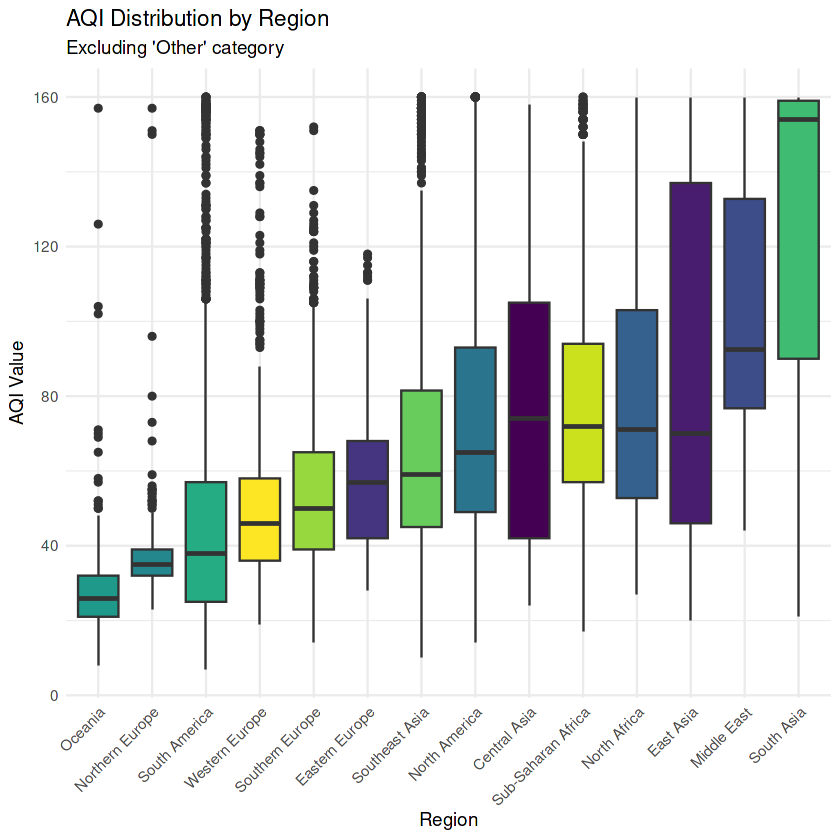

In [56]:
# Load required libraries (these should be available in Kaggle)
library(dplyr)
library(ggplot2)

# Create regional groupings
region_mapping <- list(
    "North America" = c("United States", "Canada", "Mexico", "Costa Rica", "Panama", "Guatemala", "Honduras", "El Salvador", "Nicaragua"),
    "South America" = c("Brazil", "Argentina", "Chile", "Peru", "Colombia", "Venezuela", "Ecuador", "Bolivia", "Uruguay", "Paraguay"),
    "Western Europe" = c("United Kingdom", "France", "Germany", "Netherlands", "Belgium", "Switzerland", "Austria", "Ireland", "Luxembourg"),
    "Eastern Europe" = c("Poland", "Romania", "Czech Republic", "Hungary", "Slovakia", "Bulgaria", "Croatia", "Serbia", "Slovenia"),
    "Northern Europe" = c("Sweden", "Norway", "Finland", "Denmark", "Estonia", "Latvia", "Lithuania", "Iceland"),
    "Southern Europe" = c("Spain", "Italy", "Portugal", "Greece", "Malta", "Cyprus"),
    "East Asia" = c("China", "Japan", "South Korea", "Mongolia", "Taiwan"),
    "South Asia" = c("India", "Pakistan", "Bangladesh", "Sri Lanka", "Nepal", "Bhutan"),
    "Southeast Asia" = c("Indonesia", "Thailand", "Vietnam", "Malaysia", "Philippines", "Singapore", "Myanmar", "Cambodia", "Laos"),
    "Central Asia" = c("Kazakhstan", "Uzbekistan", "Kyrgyzstan", "Tajikistan", "Turkmenistan"),
    "Middle East" = c("Saudi Arabia", "UAE", "Qatar", "Kuwait", "Oman", "Bahrain", "Iran", "Iraq", "Jordan", "Lebanon", "Israel"),
    "North Africa" = c("Egypt", "Morocco", "Tunisia", "Algeria", "Libya"),
    "Sub-Saharan Africa" = c("South Africa", "Nigeria", "Kenya", "Ethiopia", "Ghana", "Tanzania", "Uganda", "Cameroon", "Zimbabwe"),
    "Oceania" = c("Australia", "New Zealand", "Papua New Guinea", "Fiji")
)

# Add regions to your data
data <- data %>%
  mutate(Region = case_when(
    Entity %in% region_mapping[["North America"]] ~ "North America",
    Entity %in% region_mapping[["South America"]] ~ "South America",
    Entity %in% region_mapping[["Western Europe"]] ~ "Western Europe",
    Entity %in% region_mapping[["Eastern Europe"]] ~ "Eastern Europe",
    Entity %in% region_mapping[["Northern Europe"]] ~ "Northern Europe",
    Entity %in% region_mapping[["Southern Europe"]] ~ "Southern Europe",
    Entity %in% region_mapping[["East Asia"]] ~ "East Asia",
    Entity %in% region_mapping[["South Asia"]] ~ "South Asia",
    Entity %in% region_mapping[["Southeast Asia"]] ~ "Southeast Asia",
    Entity %in% region_mapping[["Central Asia"]] ~ "Central Asia",
    Entity %in% region_mapping[["Middle East"]] ~ "Middle East",
    Entity %in% region_mapping[["North Africa"]] ~ "North Africa",
    Entity %in% region_mapping[["Sub-Saharan Africa"]] ~ "Sub-Saharan Africa",
    Entity %in% region_mapping[["Oceania"]] ~ "Oceania",
    TRUE ~ "Other"
  ))

# Comprehensive regional analysis
region_summary <- data %>%
  group_by(Region) %>%
  summarise(
    n_entities = n_distinct(Entity),
    mean_AQI = mean(AQI.Value, na.rm = TRUE),
    median_AQI = median(AQI.Value, na.rm = TRUE),
    sd_AQI = sd(AQI.Value, na.rm = TRUE),
    min_AQI = min(AQI.Value, na.rm = TRUE),
    max_AQI = max(AQI.Value, na.rm = TRUE),
    q25 = quantile(AQI.Value, 0.25, na.rm = TRUE),
    q75 = quantile(AQI.Value, 0.75, na.rm = TRUE)
  ) %>%
  arrange(desc(mean_AQI))

print(region_summary)

# Visualization
p <- ggplot(data %>% filter(Region != "Other"), 
       aes(x = reorder(Region, AQI.Value), y = AQI.Value, fill = Region)) +
  geom_boxplot() +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none"  # Remove legend as it's redundant
  ) +
  labs(title = "AQI Distribution by Region",
       subtitle = "Excluding 'Other' category",
       x = "Region",
       y = "AQI Value") +
  scale_fill_viridis_d()

print(p)

library(dunn.test)

# Then run the Dunn test
dunn.test(data$AQI.Value, data$Region, 
          method="bonferroni",
          kw=TRUE)

In [46]:
########################## Modeling #########################q#

In [47]:
# Fit models
full_model <- glm(AQI.Value ~ 
                  Registered.vehicles.per.1.000.people +
                  CO.AQI.Value + 
                  NO2.AQI.Value +
                  PM2.5.AQI.Value +
                  Ozone.AQI.Value,
                  family = Gamma(link = "log"),
                  data = data)

null_model <- glm(AQI.Value ~ 1, 
                 family = Gamma(link = "log"),
                 data = data)

# Perform stepwise selection with minimal output
step_model <- step(null_model,
                  scope = list(lower = formula(null_model),
                             upper = formula(full_model)),
                  direction = "both",
                  trace = FALSE)  # Set trace to FALSE for cleaner output

# Print simplified results
cat("\nStepwise Selection Results\n")
cat("========================\n")

# Print coefficients in a cleaner format
coef_summary <- summary(step_model)$coefficients
cat("Significant predictors (in order of importance):\n")
coef_ordered <- coef_summary[order(abs(coef_summary[,"t value"]), decreasing = TRUE),]
for(i in 2:nrow(coef_ordered)) {  # Start from 2 to skip intercept
    var_name <- rownames(coef_ordered)[i]
    estimate <- round(coef_ordered[i, "Estimate"], 6)
    cat(sprintf("- %s: %f\n", var_name, estimate))
}

# Compare models
cat("\nModel Comparison (AIC):\n")
cat("- Full model:   ", round(AIC(full_model)), "\n")
cat("- Final model:  ", round(AIC(step_model)), "\n")
cat("- Null model:   ", round(AIC(null_model)), "\n")


Stepwise Selection Results
Significant predictors (in order of importance):
- PM2.5.AQI.Value: 0.011592
- Ozone.AQI.Value: 0.004892
- CO.AQI.Value: 0.011352
- NO2.AQI.Value: 0.003444
- Registered.vehicles.per.1.000.people: -0.000017

Model Comparison (AIC):
- Full model:    129206 
- Final model:   129206 
- Null model:    172104 



GLM Model Summary:

Call:
glm(formula = AQI.Value ~ Registered.vehicles.per.1.000.people + 
    CO.AQI.Value + NO2.AQI.Value + PM2.5.AQI.Value + Ozone.AQI.Value, 
    family = Gamma(link = "log"), data = data)

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           3.152e+00  4.538e-03 694.595  < 2e-16 ***
Registered.vehicles.per.1.000.people -1.675e-05  6.262e-06  -2.674  0.00749 ** 
CO.AQI.Value                          1.135e-02  1.277e-03   8.890  < 2e-16 ***
NO2.AQI.Value                         3.444e-03  4.552e-04   7.566 4.04e-14 ***
PM2.5.AQI.Value                       1.159e-02  4.134e-05 280.363  < 2e-16 ***
Ozone.AQI.Value                       4.892e-03  1.095e-04  44.674  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Gamma family taken to be 0.02794989)

    Null deviance: 5775.99  on 17194  degrees of freedom
Residual deviance:  501.1

Waiting for profiling to be done...



                                             2.5 %        97.5 %
(Intercept)                           3.142928e+00  3.161032e+00
Registered.vehicles.per.1.000.people -2.895649e-05 -4.534640e-06
CO.AQI.Value                          8.610820e-03  1.412345e-02
NO2.AQI.Value                         2.503459e-03  4.384030e-03
PM2.5.AQI.Value                       1.150881e-02  1.167443e-02
Ozone.AQI.Value                       4.680264e-03  5.104474e-03

Model Evaluation:
1. Deviance: 501.19 
2. AIC: 129205.8 
3. Null Deviance: 5775.99 
Pseudo R-squared: 0.913 


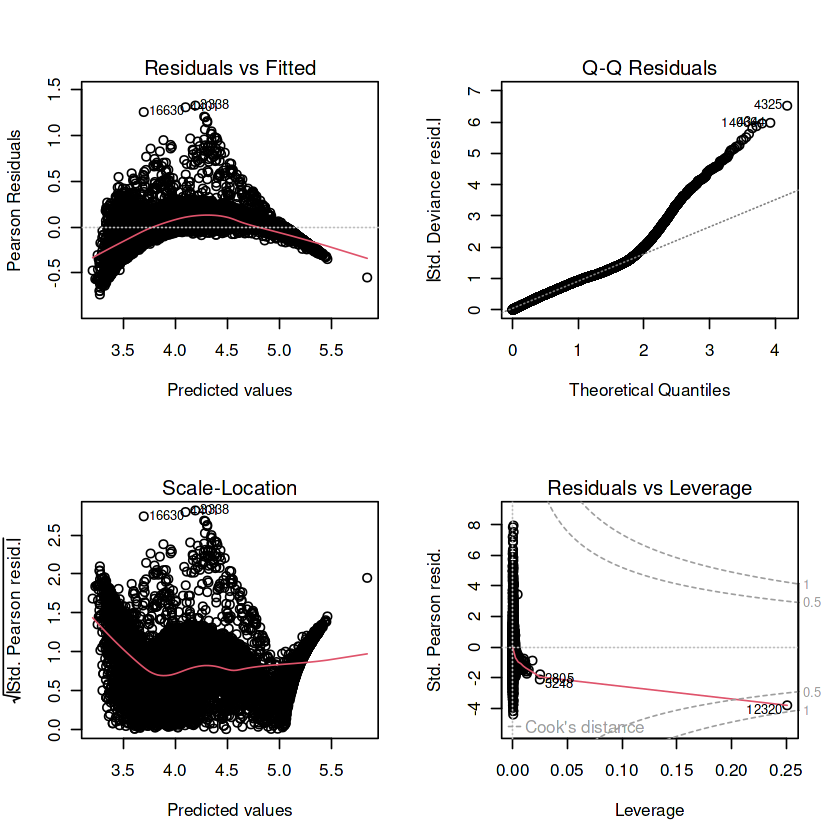

In [48]:
# Fit GLM model with Gamma distribution and log link 
# (since AQI values are continuous and positive)
final_model_glm <- glm(AQI.Value ~ 
                       Registered.vehicles.per.1.000.people +
                       CO.AQI.Value + 
                       NO2.AQI.Value +
                       PM2.5.AQI.Value +
                       Ozone.AQI.Value,
                       family = Gamma(link = "log"),
                       data = data)

# Model summary
cat("\nGLM Model Summary:\n")
cat("=================\n")
print(summary(final_model_glm))

# Confidence intervals
cat("\nConfidence Intervals (95%):\n")
cat("=========================\n")
print(confint(final_model_glm, level = 0.95))

# Diagnostic plots
par(mfrow=c(2,2))
plot(final_model_glm)

# Prediction function for GLM
predict_aqi_glm <- function(new_data) {
    predictions <- predict(final_model_glm, 
                         newdata = new_data, 
                         type = "response", 
                         se.fit = TRUE)
    
    # Calculate prediction intervals
    ci_lower <- predictions$fit - 1.96 * predictions$se.fit
    ci_upper <- predictions$fit + 1.96 * predictions$se.fit
    
    return(data.frame(
        fit = predictions$fit,
        lower = ci_lower,
        upper = ci_upper
    ))
}

# Calculate pseudo R-squared (using McFadden's method)
null_deviance <- final_model_glm$null.deviance
residual_deviance <- final_model_glm$deviance
pseudo_r_squared <- 1 - (residual_deviance / null_deviance)

# Model evaluation
cat("\nModel Evaluation:\n")
cat("================\n")
cat("1. Deviance:", round(final_model_glm$deviance, 2), "\n")
cat("2. AIC:", round(final_model_glm$aic, 2), "\n")
cat("3. Null Deviance:", round(final_model_glm$null.deviance, 2), "\n")
cat("=================\n")
cat("Pseudo R-squared:", round(pseudo_r_squared, 3), "\n")




GLM Model Results:

Significant predictors:
- PM2.5.AQI.Value: 0.011990 ***
- (Intercept): 3.253065 ***
- Ozone.AQI.Value: 0.002833 ***
- EntityArgentina: -0.383434 ***
- EntityPapua New Guinea: -0.508329 ***
- EntityMadagascar: -0.259758 ***
- EntityPeru: -0.231865 ***
- EntityAustralia: -0.243716 ***
- EntityUruguay: -0.327185 ***
- EntityNew Zealand: -0.318492 ***

Model Performance:
AIC: 125965.8 
Deviance: 409.25 
Pseudo R-squared: 0.929 


Warning message:
“not plotting observations with leverage one:
  421, 12373, 15309, 15446, 15447”


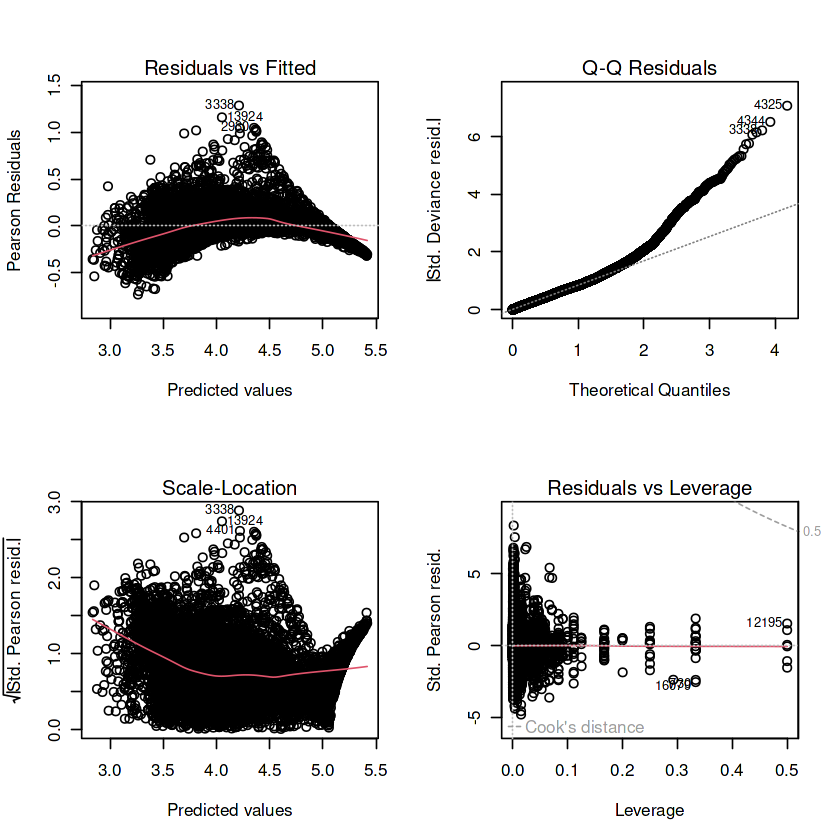

In [49]:
# Fit GLM model with Gamma distribution and log link, including Entity
final_model_glm <- glm(AQI.Value ~ 
                       Entity +  # Added categorical variable
                       Registered.vehicles.per.1.000.people +
                       CO.AQI.Value + 
                       NO2.AQI.Value +
                       PM2.5.AQI.Value +
                       Ozone.AQI.Value,
                       family = Gamma(link = "log"),
                       data = data)

# Simplified model summary output
cat("\nGLM Model Results:\n")
cat("================\n")
coef_summary <- summary(final_model_glm)$coefficients

# Print coefficients by significance
cat("\nSignificant predictors:\n")
coef_ordered <- coef_summary[order(abs(coef_summary[,"t value"]), decreasing = TRUE),]
for(i in 1:10) {  # Print top 10 most significant predictors
    if(i <= nrow(coef_ordered)) {
        var_name <- rownames(coef_ordered)[i]
        estimate <- round(coef_ordered[i, "Estimate"], 6)
        p_value <- coef_ordered[i, "Pr(>|t|)"]
        significance <- if(p_value < 0.001) "***" else if(p_value < 0.01) "**" else if(p_value < 0.05) "*" else ""
        cat(sprintf("- %s: %f %s\n", var_name, estimate, significance))
    }
}

# Model fit statistics
cat("\nModel Performance:\n")
cat("=================\n")
cat("AIC:", round(final_model_glm$aic, 2), "\n")
cat("Deviance:", round(final_model_glm$deviance, 2), "\n")
cat("Pseudo R-squared:", round(1 - (final_model_glm$deviance/final_model_glm$null.deviance), 3), "\n")

# Diagnostic plots
par(mfrow=c(2,2))
plot(final_model_glm)

In [50]:
# Load required packages
library(mgcv)   # For GAM
library(nlme)   # For NLS

# Original GLM model
final_model_glm <- glm(AQI.Value ~ 
                       Entity +  
                       Registered.vehicles.per.1.000.people +
                       CO.AQI.Value + 
                       NO2.AQI.Value +
                       PM2.5.AQI.Value +
                       Ozone.AQI.Value,
                       family = Gamma(link = "log"),
                       data = data)

# GAM model
gam_model <- gam(AQI.Value ~ 
                 Entity +
                 s(Registered.vehicles.per.1.000.people) +
                 s(CO.AQI.Value) + 
                 s(NO2.AQI.Value) +
                 s(PM2.5.AQI.Value) +
                 s(Ozone.AQI.Value),
                 family = Gamma(link = "log"),
                 data = data)

# NLS model - with try() to handle potential convergence issues
nls_model <- try(nls(AQI.Value ~ a * exp(b * PM2.5.AQI.Value + c * Ozone.AQI.Value),
                     data = data,
                     start = list(a = 1, b = 0.01, c = 0.01)))

# Function to calculate R-squared for GLM
glm_r2 <- function(model) {
   1 - model$deviance/model$null.deviance
}

# Function to calculate R-squared for GAM
gam_r2 <- function(model) {
   summary(model)$dev.expl  # This gives R-squared equivalent for GAM
}

# Function to calculate R-squared for NLS
nls_r2 <- function(model, data) {
   if(!inherits(model, "try-error")) {
       residuals <- residuals(model)
       ss_res <- sum(residuals^2)
       ss_tot <- sum((data$AQI.Value - mean(data$AQI.Value))^2)
       return(1 - ss_res/ss_tot)
   } else {
       return(NA)
   }
}

# Calculate and print model comparison metrics
cat("\nModel R-squared Comparison:\n")
cat("========================\n")
cat("GLM R-squared:", round(glm_r2(final_model_glm), 3), "\n")
cat("GAM R-squared:", round(gam_r2(gam_model), 3), "\n")
if(!inherits(nls_model, "try-error")) {
   cat("NLS R-squared:", round(nls_r2(nls_model, data), 3), "\n")
}

# AIC comparison
cat("\nAIC Comparison:\n")
cat("===============\n")
cat("GLM AIC:", round(AIC(final_model_glm), 2), "\n")
cat("GAM AIC:", round(AIC(gam_model), 2), "\n")
if(!inherits(nls_model, "try-error")) {
   cat("NLS AIC:", round(AIC(nls_model), 2), "\n")
}

# Additional model diagnostics
cat("\nModel Summary Statistics:\n")
cat("======================\n")
cat("\nGLM Summary:\n")
cat("Null deviance:", round(final_model_glm$null.deviance, 2), "\n")
cat("Residual deviance:", round(final_model_glm$deviance, 2), "\n")

cat("\nGAM Summary:\n")
cat("GCV score:", round(gam_model$gcv.ubre, 4), "\n")
cat("Scale estimate:", round(gam_model$scale, 4), "\n")

if(!inherits(nls_model, "try-error")) {
    cat("\nNLS Summary:\n")
    cat("Residual standard error:", round(summary(nls_model)$sigma, 4), "\n")
}

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:forecast’:

    getResponse


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.




Model R-squared Comparison:
GLM R-squared: 0.929 
GAM R-squared: 0.961 
NLS R-squared: 0.947 

AIC Comparison:
GLM AIC: 125965.8 
GAM AIC: 115797.9 
NLS AIC: 127582.5 

Model Summary Statistics:

GLM Summary:
Null deviance: 5775.99 
Residual deviance: 409.25 

GAM Summary:
GCV score: 0.0134 
Scale estimate: 0.0135 

NLS Summary:
Residual standard error: 9.8827 



GLM Performance:
RMSE: 11.999 
MAE: 7.888 

GAM Performance:
RMSE: 7.155 
MAE: 4.671 

NLS Performance:
RMSE: 9.414 
MAE: 6.88 


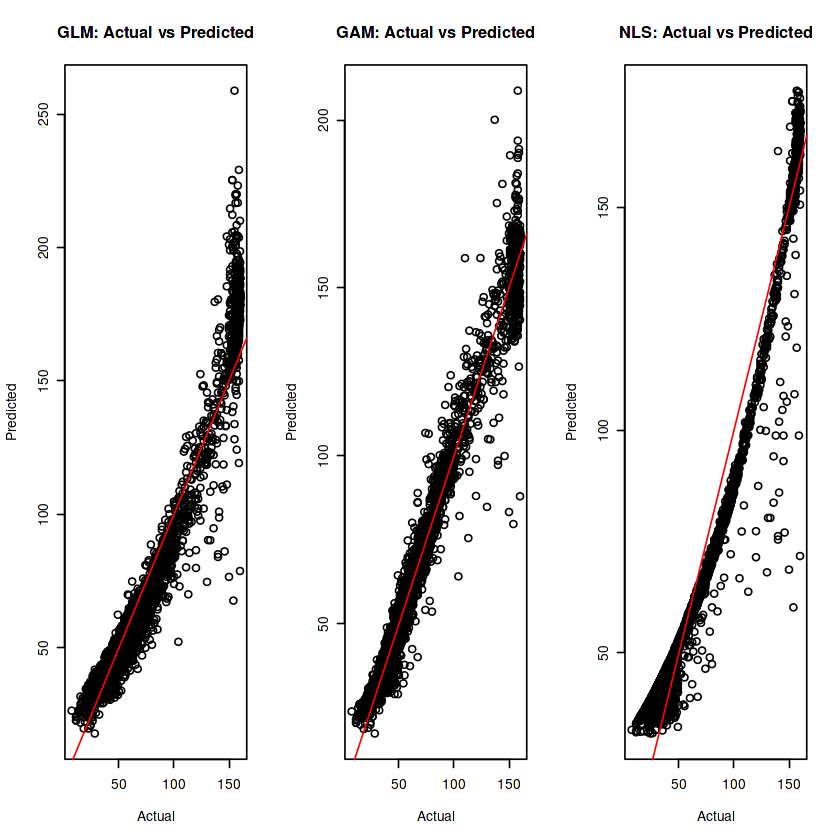

In [51]:
# Create test data (20% of original data)
set.seed(123)  # for reproducibility
sample_index <- sample(1:nrow(data), 0.2 * nrow(data))
train_data <- data[-sample_index, ]
test_data <- data[sample_index, ]

# Function to calculate prediction metrics
evaluate_model <- function(true_values, predicted_values, model_name) {
    # Calculate metrics
    mse <- mean((true_values - predicted_values)^2)
    rmse <- sqrt(mse)
    mae <- mean(abs(true_values - predicted_values))
    
    # Print results
    cat(sprintf("\n%s Performance:\n", model_name))
    cat("==================\n")
    cat("RMSE:", round(rmse, 3), "\n")
    cat("MAE:", round(mae, 3), "\n")
}

# Fit models on training data
glm_train <- glm(AQI.Value ~ Entity + Registered.vehicles.per.1.000.people +
                 CO.AQI.Value + NO2.AQI.Value + PM2.5.AQI.Value + Ozone.AQI.Value,
                 family = Gamma(link = "log"), data = train_data)

gam_train <- gam(AQI.Value ~ Entity + 
                 s(Registered.vehicles.per.1.000.people) +
                 s(CO.AQI.Value) + s(NO2.AQI.Value) +
                 s(PM2.5.AQI.Value) + s(Ozone.AQI.Value),
                 family = Gamma(link = "log"), data = train_data)

nls_train <- try(nls(AQI.Value ~ a * exp(b * PM2.5.AQI.Value + c * Ozone.AQI.Value),
                     data = train_data,
                     start = list(a = 1, b = 0.01, c = 0.01)))

# Make predictions on test data
glm_pred <- predict(glm_train, newdata = test_data, type = "response")
gam_pred <- predict(gam_train, newdata = test_data, type = "response")
if(!inherits(nls_train, "try-error")) {
    nls_pred <- predict(nls_train, newdata = test_data)
}

# Evaluate models
evaluate_model(test_data$AQI.Value, glm_pred, "GLM")
evaluate_model(test_data$AQI.Value, gam_pred, "GAM")
if(!inherits(nls_train, "try-error")) {
    evaluate_model(test_data$AQI.Value, nls_pred, "NLS")
}

# Plot actual vs predicted values
par(mfrow=c(1,3))
plot(test_data$AQI.Value, glm_pred, 
     main="GLM: Actual vs Predicted",
     xlab="Actual", ylab="Predicted")
abline(0,1, col="red")

plot(test_data$AQI.Value, gam_pred, 
     main="GAM: Actual vs Predicted",
     xlab="Actual", ylab="Predicted")
abline(0,1, col="red")

if(!inherits(nls_train, "try-error")) {
    plot(test_data$AQI.Value, nls_pred, 
         main="NLS: Actual vs Predicted",
         xlab="Actual", ylab="Predicted")
    abline(0,1, col="red")
}

In [52]:
########################## Deployement ##########################

In [53]:
# Export the GAM model
saveRDS(gam_train, "air_quality_gam.rds")

# Export the cleaned dataset
# Assuming 'data' is your cleaned dataframe
write.csv(data, "cleaned_air_quality_data.csv", row.names = FALSE)

# If you want to save just the training data
write.csv(train_data, "air_quality_train_data.csv", row.names = FALSE)

# If you want to save test data too
write.csv(test_data, "air_quality_test_data.csv", row.names = FALSE)